In [1]:
import re
import pandas as pd
from textblob import Word
from vaderSentiment.vaderSentiment import SentimentIntensityAnalyzer
import warnings
warnings.filterwarnings('once')
from IPython.display import display
pd.set_option('display.max_columns', None)
display()
import matplotlib.pyplot as plt
%matplotlib inline

folderpath='./OccupationBank/'

In [2]:
def vaderize(df, textfield):
    '''Compute the Vader polarity scores for a textfield.
    Returns scores and original dataframe.'''
    sid = SentimentIntensityAnalyzer()
    print('Estimating polarity scores for %d cases.' % len(df))    
    df['compound'] = df[textfield].apply(sid.polarity_scores)
    df_vader = pd.concat([df.drop(['compound'], axis=1), df['compound'].apply(pd.Series)], axis=1)
    print('Positive word count---{} '.format(df_vader.pos.sum()))
    print('Negative word count---{} '.format(df_vader.neg.sum()))
    print('Neutral word count---{} '.format(df_vader.neu.sum()))
    return df_vader

In [3]:
'''
*  = indicates that a wage estimate is not available
#  = indicates a wage equal to or greater than $100.00 per hour or $208,000 per year 
'''
cols = [
        'OCC_CODE',
        'OCC_TITLE',
        'TOT_EMP',
        'EMP_PRSE',
        'A_MEAN',
        'MEAN_PRSE',
        'A_PCT10',
        'A_PCT25',
        'A_MEDIAN',
        'A_PCT75',
        'A_PCT90'
        ]
dtype_dic = {'OCC_CODE': str,'OCC_TITLE':str,}

jt = pd.read_csv("OEWS21_OccupationsDetailedView.csv", usecols= cols,
                                            dtype=dtype_dic, 
                                            na_values= r"*",
                                            keep_default_na=True)
jt.columns = jt.columns.str.lower()
print(len(jt))

831


In [4]:
jt = jt[~jt['a_mean'].isnull()]
print(len(jt))

825


In [5]:
thous_cols = [
             'tot_emp',
             'a_mean',
             'a_pct10',
             'a_pct25',
             'a_median',
             'a_pct75',
             'a_pct90'
             ]

jt= jt.apply(lambda x: x.str.replace('#','208000') if x.name in thous_cols else x)
jt= jt.apply(lambda x: x.str.replace(',','') if x.name in thous_cols else x)
jt= jt.apply(lambda x: x.fillna('0') if x.name in thous_cols else x)
jt = jt.apply(lambda x: x.astype(float) if x.name in thous_cols else x)

In [6]:
jt.head(10)

,occ_code,occ_title,tot_emp,emp_prse,a_mean,mean_prse,a_pct10,a_pct25,a_median,a_pct75,a_pct90
0,11-1011,Chief Executives,200480.0,1.6,213020.0,0.8,60300.0,111080.0,179520.0,208000.0,208000.0
1,11-1021,General and Operations Managers,2984920.0,0.5,115250.0,0.4,43260.0,60690.0,97970.0,151750.0,208000.0
2,11-1031,Legislators,44590.0,2.7,57110.0,1.8,17850.0,22880.0,37270.0,78510.0,100580.0
3,11-2011,Advertising and Promotions Managers,22520.0,3.4,142860.0,1.9,61250.0,94020.0,127150.0,172210.0,208000.0
4,11-2021,Marketing Managers,278690.0,1.0,153440.0,0.5,77680.0,100010.0,135030.0,192520.0,208000.0
5,11-2022,Sales Managers,453800.0,1.2,142390.0,0.4,61090.0,84450.0,127490.0,173010.0,208000.0
6,11-2032,Public Relations Managers,59850.0,2.2,138000.0,0.9,66000.0,94660.0,125780.0,164830.0,208000.0
7,11-2033,Fundraising Managers,23190.0,1.8,119400.0,0.8,60400.0,77170.0,100810.0,150920.0,204430.0
8,11-3012,Administrative Services Managers,224620.0,0.7,113030.0,0.4,59470.0,77070.0,100170.0,131130.0,168910.0
9,11-3013,Facilities Managers,101230.0,1.3,101970.0,0.5,59010.0,74700.0,97930.0,125940.0,161140.0


In [7]:
pats = [  
          ' or ',
          'and', 
          'except',  
          '/'
       ]
 

pattern = '|'.join(pats)

jt_norm = jt[~jt['occ_title'].str.contains(pattern, case=False)]
print(len(jt_norm))
jt_dir = jt[jt['occ_title'].str.contains(pattern, case=False)]
print(len(jt_dir))

410
415


In [8]:
def clean_string(string):
    string = string.lower()
    chars_to_remove = [")","(",".","|","[","]","{","}","'",'"']
    rx = '[' + re.escape(''.join(chars_to_remove)) + ']'
    string = re.sub(rx, '', string)
    string = re.sub(', all other', '', string)
    string = re.sub('helpers--', 'assistant ', string)
    string = Word(string).singularize()    
    string = string.strip()
    string = string.rstrip()
    string = re.sub(' +',' ',string).strip()
    return string

In [9]:
jt_norm['norm_title'] = jt_norm['occ_title'].apply(lambda x: clean_string(x))


/wgsprod/data/home/TRSSLLC/savrozenbaum/miniconda3/envs/greatsuccess2/lib/python3.7/site-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.


In [10]:
jt_norm.head()

,occ_code,occ_title,tot_emp,emp_prse,a_mean,mean_prse,a_pct10,a_pct25,a_median,a_pct75,a_pct90,norm_title
0,11-1011,Chief Executives,200480.0,1.6,213020.0,0.8,60300.0,111080.0,179520.0,208000.0,208000.0,chief executive
2,11-1031,Legislators,44590.0,2.7,57110.0,1.8,17850.0,22880.0,37270.0,78510.0,100580.0,legislator
4,11-2021,Marketing Managers,278690.0,1.0,153440.0,0.5,77680.0,100010.0,135030.0,192520.0,208000.0,marketing manager
5,11-2022,Sales Managers,453800.0,1.2,142390.0,0.4,61090.0,84450.0,127490.0,173010.0,208000.0,sales manager
6,11-2032,Public Relations Managers,59850.0,2.2,138000.0,0.9,66000.0,94660.0,125780.0,164830.0,208000.0,public relations manager


In [11]:
jt_normv = vaderize(jt_norm, 'norm_title')

Estimating polarity scores for 410 cases.
Positive word count---9.974 
Negative word count---3.993 
Neutral word count---396.033 


/wgsprod/data/home/TRSSLLC/savrozenbaum/miniconda3/envs/greatsuccess2/lib/python3.7/site-packages/ipykernel_launcher.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  


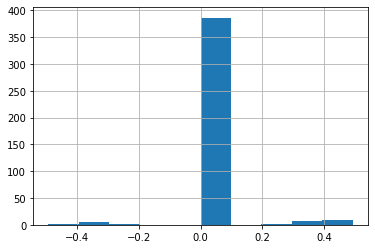

In [12]:
jt_normv.compound.hist()

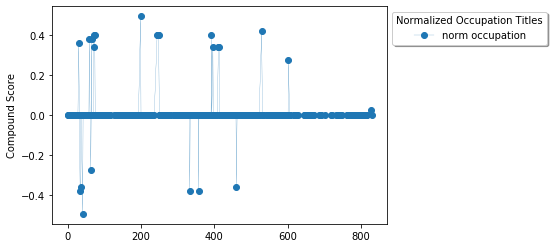

In [13]:
# Plot compound sentiment
jt_normv['compound'].plot(marker='o', linewidth= .2, label='norm occupation')
plt.ylabel('Compound Score')
# Plot line for average compound score
avg_occ = jt_normv['compound'].mean()
plt.hlines(avg_occ, 0, len(jt_normv), linewidth=.5, linestyle='dotted', color='green')
plt.legend(title="Normalized Occupation Titles", loc='center left', bbox_to_anchor=(1, .9), fancybox=True, shadow=True,)

In [14]:
neu = (jt_normv['compound']==0.0).values 
pos =  ((jt_normv['compound']>0.0) & (jt_normv['compound']<=.4)).values
vpos= (jt_normv['compound']>.4).values
neg = ((jt_normv['compound']<0.0) & (jt_normv['compound']>= -0.4)).values
vneg = (jt_normv['compound']<-0.4).values

jt_normv['sentiment_cat'] = 0
jt_normv['sentiment_cat'][vneg]=1
jt_normv['sentiment_cat'][neg]=2
jt_normv['sentiment_cat'][neu]=3
jt_normv['sentiment_cat'][pos]=4
jt_normv['sentiment_cat'][vpos]=5

/wgsprod/data/home/TRSSLLC/savrozenbaum/miniconda3/envs/greatsuccess2/lib/python3.7/site-packages/ipykernel_launcher.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  


In [15]:
jt_normv = jt_normv.sort_values('a_mean')

In [16]:
jt_normv

,occ_code,occ_title,tot_emp,emp_prse,a_mean,mean_prse,a_pct10,a_pct25,a_median,a_pct75,a_pct90,norm_title,neg,neu,pos,compound,sentiment_cat
466,39-5093,Shampooers,9560.0,11.2,25160.0,2.6,18720.0,22070.0,24440.0,28860.0,30420.0,shampooer,0.000,1.000,0.0,0.0000,3
419,35-2011,"Cooks, Fast Food",768130.0,2.2,25490.0,0.6,18050.0,21610.0,24180.0,29510.0,31420.0,"cooks, fast food",0.000,1.000,0.0,0.0000,3
478,41-2011,Cashiers,3318020.0,0.5,26770.0,0.2,18580.0,22670.0,27260.0,29540.0,35230.0,cashier,0.000,1.000,0.0,0.0000,3
431,35-9021,Dishwashers,377040.0,1.6,27350.0,0.5,19200.0,22920.0,28130.0,30160.0,34870.0,dishwasher,0.000,1.000,0.0,0.0000,3
471,39-9011,Childcare Workers,438520.0,1.6,27680.0,0.5,18540.0,22640.0,27490.0,30100.0,37430.0,childcare worker,0.000,1.000,0.0,0.0000,3
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
341,29-1224,Radiologists,29530.0,9.2,301720.0,2.9,78780.0,165610.0,208000.0,208000.0,208000.0,radiologist,0.000,1.000,0.0,0.0000,3
332,29-1213,Dermatologists,9230.0,13.1,302740.0,4.3,100940.0,170020.0,208000.0,208000.0,208000.0,dermatologist,0.000,1.000,0.0,0.0000,3
333,29-1214,Emergency Medicine Physicians,36180.0,8.9,310640.0,2.2,103310.0,208000.0,208000.0,208000.0,208000.0,emergency medicine physician,0.565,0.435,0.0,-0.3818,2
330,29-1211,Anesthesiologists,31130.0,8.1,331190.0,2.0,117590.0,208000.0,208000.0,208000.0,208000.0,anesthesiologist,0.000,1.000,0.0,0.0000,3


In [17]:
jt_normv.describe()

,tot_emp,emp_prse,a_mean,mean_prse,a_pct10,a_pct25,a_median,a_pct75,a_pct90,neg,neu,pos,compound,sentiment_cat
count,4.100000e+02,410.000000,410.000000,410.000000,410.000000,410.000000,410.000000,410.000000,410.000000,410.000000,410.000000,410.000000,410.000000,410.000000
mean,1.507427e+05,3.708537,76969.707317,1.395122,41047.512195,53262.707317,69194.609756,87243.390244,107197.829268,0.009739,0.965934,0.024327,0.009458,3.046341
std,3.869273e+05,3.917586,51216.626459,1.632577,18829.432162,29685.696987,40105.556596,46132.357429,52363.584375,0.074435,0.136327,0.116273,0.092402,0.363760
min,2.100000e+02,0.000000,25160.000000,0.000000,17740.000000,18600.000000,24180.000000,28860.000000,30420.000000,0.000000,0.192000,0.000000,-0.493900,1.000000
25%,1.350750e+04,1.400000,43457.500000,0.500000,28492.500000,31010.000000,38662.500000,49135.000000,61527.500000,0.000000,1.000000,0.000000,0.000000,3.000000
50%,3.919000e+04,2.450000,62335.000000,0.900000,36840.000000,46590.000000,60080.000000,76900.000000,95275.000000,0.000000,1.000000,0.000000,0.000000,3.000000
75%,1.244000e+05,4.700000,94337.500000,1.600000,49090.000000,62877.500000,82500.000000,107680.000000,151775.000000,0.000000,1.000000,0.000000,0.000000,3.000000
max,3.693490e+06,30.400000,353970.000000,18.300000,165610.000000,208000.000000,208000.000000,208000.000000,208000.000000,0.714000,1.000000,0.808000,0.493900,5.000000


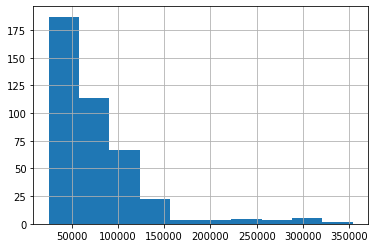

In [18]:
jt_normv.a_mean.hist()

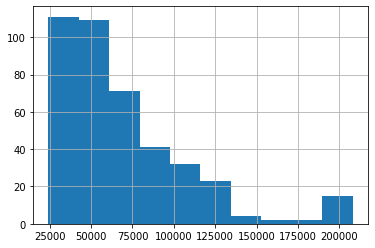

In [19]:
jt_normv.a_median.hist()

In [20]:
vlow = jt_normv.loc[jt_normv['a_median']<=35000.0]
print(len(vlow))
low = jt_normv.loc[(jt_normv['a_median']>35000.0) & (jt_normv['a_median']<=50000.0)]
print(len(low))
medium = jt_normv.loc[(jt_normv['a_median']>50000.0) & (jt_normv['a_median']<=80000.0)]
print(len(medium))
high = jt_normv.loc[(jt_normv['a_median']>80000.0) & (jt_normv['a_median']<=105000.0)]
print(len(high))
vhigh =jt_normv.loc[jt_normv['a_median']>105000.0]
print(len(vhigh))

50
133
114
61
52


In [21]:
vlow = (jt_normv['a_median']<=35000.0).values 
low =  ((jt_normv['a_median']>35000.0) & (jt_normv['a_median']<=50000.0)).values
middle= ((jt_normv['a_median']>50000.0) & (jt_normv['a_median']<=80000.0)).values
high = ((jt_normv['a_median']>80000.0) & (jt_normv['a_median']<=105000.0)).values
vhigh = (jt_normv['a_median']>105000.0).values

jt_normv['wage_cat'] = 0
jt_normv['wage_cat'][vlow]=1
jt_normv['wage_cat'][low]=2
jt_normv['wage_cat'][middle]=3
jt_normv['wage_cat'][high]=4
jt_normv['wage_cat'][vhigh]=5

/wgsprod/data/home/TRSSLLC/savrozenbaum/miniconda3/envs/greatsuccess2/lib/python3.7/site-packages/ipykernel_launcher.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  


In [22]:
jt_normv.to_csv(folderpath+'AnnualOccupations_TitleBank.csv',index=False)